# Earthquake Prediction using Machine Leaning

This project uses historical earthquake data to build a model that predicts the magnitude of an earthquake based on location, depth, and other parameters.

**Goal:** Predict the `Magnitude` of an earthquake using regression techniques.

---

### Dataset Overview
The dataset contains global earthquake records with features such as:

-Geographic info (Latitude, Longitude)

-Seismic details (Depth, Magnitude, RMS)

-Temporal data (Date, Time)

-Sensor metadata (Seismic Stations, Errors, etc.)

We’ll use this data to build predictive models.

In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

In [23]:
# Load dataset
df = pd.read_csv("database.csv")

# Display shape and sample data
print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (23412, 21)


,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic


## EDA

In [24]:
# Overview of missing values and data types
df.info()
df.isnull().sum().sort_values(ascending=False).head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23412 entries, 0 to 23411
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        23412 non-null  object 
 1   Time                        23412 non-null  object 
 2   Latitude                    23412 non-null  float64
 3   Longitude                   23412 non-null  float64
 4   Type                        23412 non-null  object 
 5   Depth                       23412 non-null  float64
 6   Depth Error                 4461 non-null   float64
 7   Depth Seismic Stations      7097 non-null   float64
 8   Magnitude                   23412 non-null  float64
 9   Magnitude Type              23409 non-null  object 
 10  Magnitude Error             327 non-null    float64
 11  Magnitude Seismic Stations  2564 non-null   float64
 12  Azimuthal Gap               7299 non-null   float64
 13  Horizontal Distance         160

Magnitude Error               23085
Horizontal Error              22256
Horizontal Distance           21808
Magnitude Seismic Stations    20848
Depth Error                   18951
Depth Seismic Stations        16315
Azimuthal Gap                 16113
Root Mean Square               6060
Magnitude Type                    3
Magnitude Source                  0
dtype: int64

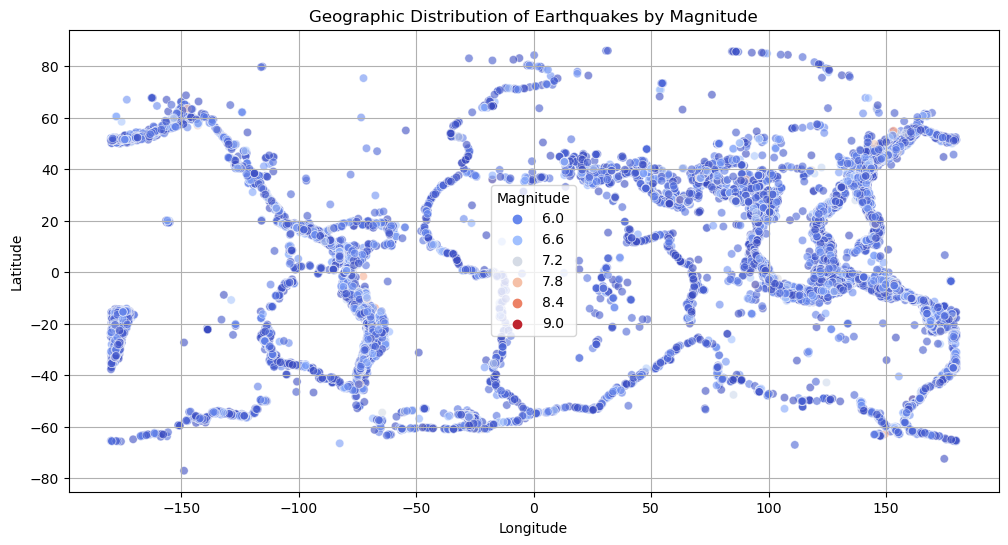

In [25]:
#Geospatial Distribution of Earthquakes
plt.figure(figsize=(12,6))
sns.scatterplot(data=df, x='Longitude', y='Latitude', hue='Magnitude', palette='coolwarm', alpha=0.6)
plt.title("Geographic Distribution of Earthquakes by Magnitude")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Magnitude")
plt.grid(True)
plt.show()


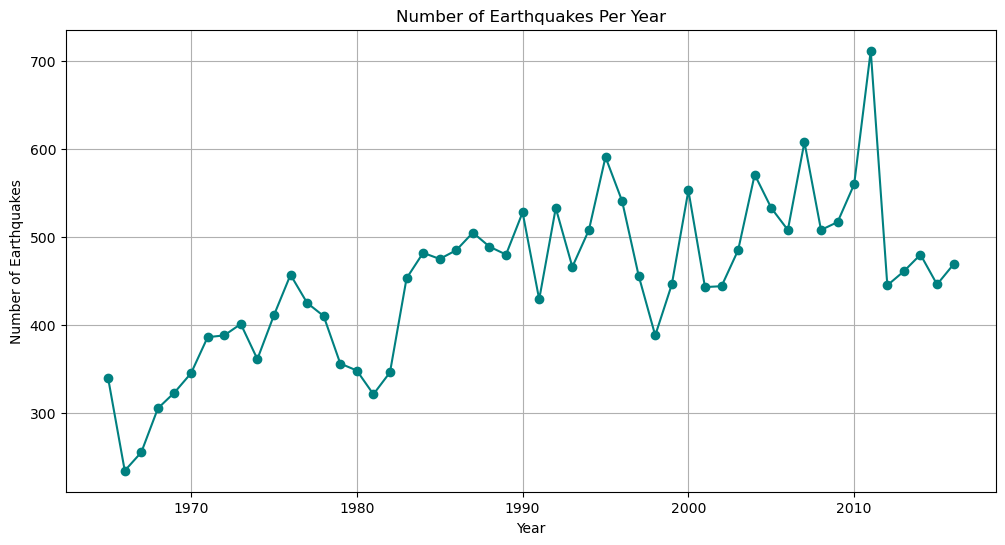

In [26]:
# Convert Date column to datetime (if not done yet)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Earthquake frequency by year
df['Year'] = df['Date'].dt.year
earthquake_count_by_year = df['Year'].value_counts().sort_index()

plt.figure(figsize=(12,6))
earthquake_count_by_year.plot(kind='line', marker='o', color='teal')
plt.title("Number of Earthquakes Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Earthquakes")
plt.grid(True)
plt.show()


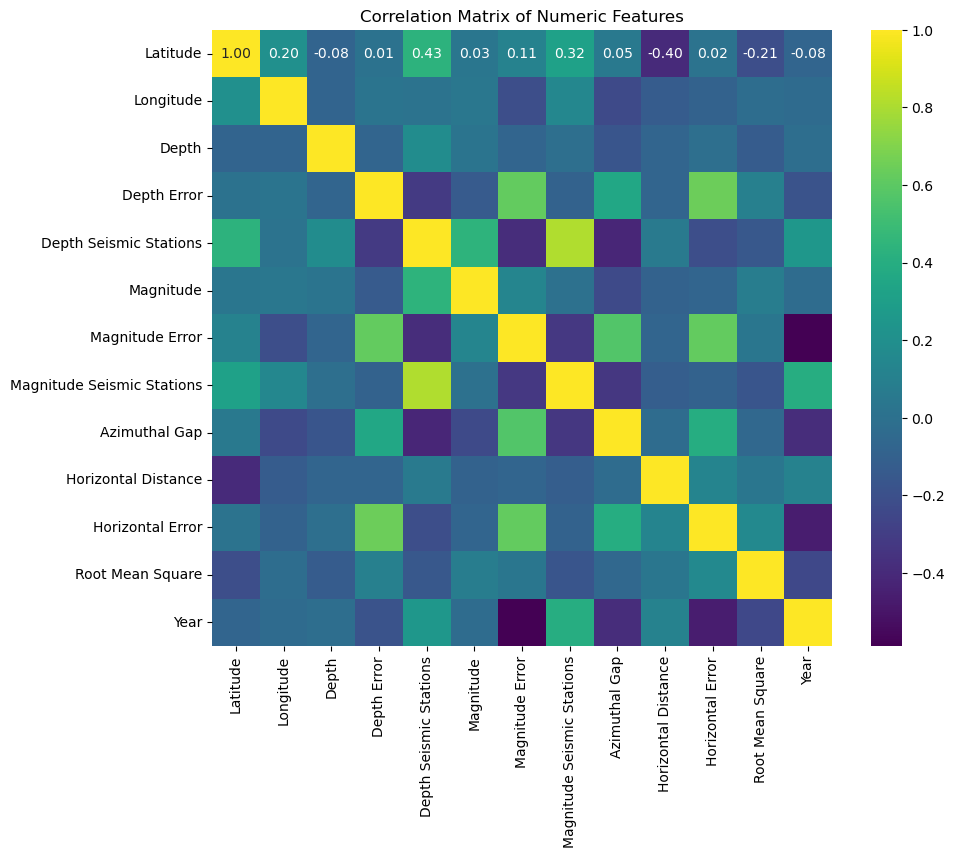

In [27]:
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Compute correlation
plt.figure(figsize=(10,8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='viridis', fmt=".2f")
plt.title("Correlation Matrix of Numeric Features")
plt.show()


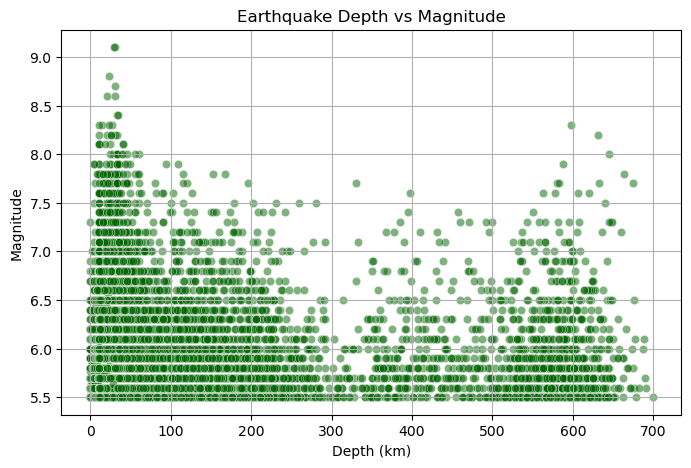

In [28]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='Depth', y='Magnitude', alpha=0.5, color='darkgreen')
plt.title("Earthquake Depth vs Magnitude")
plt.xlabel("Depth (km)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.show()


##  Data Preprocessing

In [29]:
# Drop columns with too many missing values or irrelevant info
df = df.drop(columns=[
    'ID', 'Source', 'Location Source', 'Magnitude Source',
    'Status', 'Depth Error', 'Depth Seismic Stations', 
    'Magnitude Error', 'Magnitude Seismic Stations',
    'Azimuthal Gap', 'Horizontal Distance', 
    'Horizontal Error'
])

# Drop rows with missing Magnitude
df = df.dropna(subset=['Magnitude'])

# Fill remaining NaNs (e.g., Root Mean Square)
df['Root Mean Square'] = df['Root Mean Square'].fillna(df['Root Mean Square'].median())

# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop rows where Date couldn't be converted
df = df.dropna(subset=['Date'])

# Encode categorical column: Magnitude Type
df['Magnitude Type'] = LabelEncoder().fit_transform(df['Magnitude Type'].astype(str))

df.head()

,Date,Time,Latitude,Longitude,Type,Depth,Magnitude,Magnitude Type,Root Mean Square,Year
0,1965-01-02,13:44:18,19.246,145.616,Earthquake,131.6,6.0,5,1.0,1965.0
1,1965-01-04,11:29:49,1.863,127.352,Earthquake,80.0,5.8,5,1.0,1965.0
2,1965-01-05,18:05:58,-20.579,-173.972,Earthquake,20.0,6.2,5,1.0,1965.0
3,1965-01-08,18:49:43,-59.076,-23.557,Earthquake,15.0,5.8,5,1.0,1965.0
4,1965-01-09,13:32:50,11.938,126.427,Earthquake,15.0,5.8,5,1.0,1965.0


##  Feature Engineering

In [30]:
# Select features and target
features = ['Latitude', 'Longitude', 'Depth', 'Root Mean Square', 'Magnitude Type']
X = df[features]
y = df['Magnitude']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((18727, 5), (4682, 5))

In [31]:
#comparison of different models

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# Dictionary of models
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Support Vector Regressor": SVR()
}

results = []

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((name, rmse, r2))

# Display results
comparison_df = pd.DataFrame(results, columns=["Model", "RMSE", "R2 Score"])
comparison_df.sort_values(by="RMSE")


,Model,RMSE,R2 Score
0,Random Forest,0.415323,0.072273
1,Linear Regression,0.421569,0.044158
3,Support Vector Regressor,0.435715,-0.021064
2,Decision Tree,0.549833,-0.625964


##  Model Building with Random Forest Regressor

In [32]:
# Build and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

##  Model Evaluation

In [33]:
# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Root Mean Squared Error (RMSE):", rmse)
print("R^2 Score:", r2)

Root Mean Squared Error (RMSE): 0.4153227687299859
R^2 Score: 0.07227321561029665


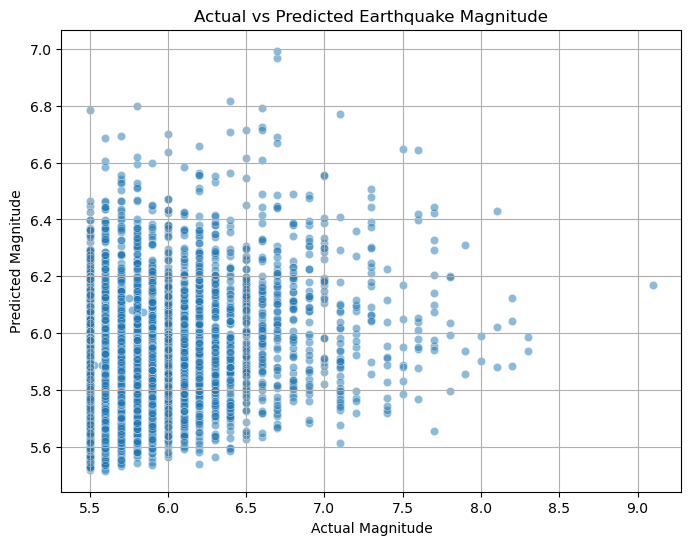

In [34]:
# Plot true vs predicted magnitudes
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.xlabel("Actual Magnitude")
plt.ylabel("Predicted Magnitude")
plt.title("Actual vs Predicted Earthquake Magnitude")
plt.grid(True)
plt.show()